In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import copy
import os

import sys
import time
from scipy.stats import norm

#import prettyplotlib as ppl
#import numpy as np
import matplotlib as mpl
#from prettyplotlib import brewer2mpl
import matplotlib.pyplot as plt
import matplotx
import numpy as np
import pandas as pd
import seaborn as sns

from helper import df_to_latex, fig_path, set_figsize, tab_path

# Import code from src
sys.path.insert(0, '../src/')
import vmc 

In [ ]:
pd.set_option('display.max_columns', 50)
#pd.options.display.float_format= '{e:.5f}'.format 
# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"}, palette="Set2")

fontsize = "large"

params = {"font.family": "serif",
          "font.sans-serif": ["Computer Modern"],
          "axes.labelsize": fontsize,
          #"font.size": fontsize,
          "legend.fontsize": fontsize,
          "xtick.labelsize": fontsize,
          "ytick.labelsize": fontsize,
          "legend.handlelength": 2
         }
          
    
plt.rcParams.update(params)
plt.rc('text', usetex=True)

In [5]:
def exact_energy(N, dim, omega):
    return (omega * dim * N) / 2

def safe_initial_positions_no_interactions(wavefunction, alpha, N, dim, seed=None):
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))

    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14:
        positions *= 0.5
        wf2 = wavefunction.pdf(positions, alpha)

    return positions

def safe_initial_positions_w_interactions(wavefunction, alpha, N, dim, seed=None): 
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))
    
    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14: 
        positions *= 2.0
        wf2 = wavefunction.pdf(positions, alpha)
        
    return positions

def interact_initial_positions(wf, alpha, N, dim, a=0.00433):

    rng = np.random.default_rng()

    def corr_factor(r1, r2):
        rij = np.linalg.norm(r1 - r2)
        if rij <= a:
            return 0.
        else:
            return 1 - (a / rij)

    scale = 2.
    r = np.random.randn(N, dim) * scale
    #r = rng.random(size=(N, dim))

    rerun = True
    while rerun:
        rerun = False
        for i in range(N):
            for j in range(i + 1, N):
                corr = corr_factor(r[i, :], r[j, :])
                if corr == 0.:
                    print("corr=0 encountered")
                    rerun = True
                    r[i, :] = np.random.randn() * scale
                    r[j, :] = np.random.randn() * scale
        scale *= 1.5

    return r, scale

def get_mean_w_standard_error_grid_search(data, alphas): 
    data_dict = {"alpha": alphas, "energy": [], "standard_error":[],"standard_error_of_the_mean": []}
    for i, alpha in enumerate(alphas): 
        energies_alpha = data["energy"][data["alpha"]==alpha]
        standard_errors_alpha = data["standard_error"][data["alpha"]==alpha]
        mean_energy_alpha = np.mean(energies_alpha)
        standard_error = np.mean(standard_errors_alpha)
        standard_error_of_the_mean = np.std(standard_errors_alpha)/np.sqrt(len(standard_errors_alpha))
        data_dict["energy"].append(mean_energy_alpha)
        data_dict["standard_error"].append(standard_error)
        data_dict["standard_error_of_the_mean"].append(standard_error_of_the_mean)
        
    dataframe = pd.DataFrame(data=data_dict)
    return dataframe


In [6]:
cycle=["#82e2ff",  # blue
       "#ffca85",  # orange
       "#61ffca",  # green
       "#ff6767",  # red
       "#a277ff",  # purple
       "#f694ff",  # magenta
       "#6d6d6d",  # gray
       ]



def plotter(data, sampler, label_N_particles, label_time, label_sigma, index): 
    N_range = data[label_N_particles]
    t_array = data[label_time]
    std = data[label_sigma]
    plt.plot(N_range, t_array, label=sampler, color=cycle[index]) 
    plt.errorbar(N_range,
                 t_array,
                 yerr=std,
                 fmt=':o',
                 color=cycle[index],
                 ecolor=cycle[index],
                 markersize=3.5,
                 lw=1.0,
                 elinewidth=1.5,
                 capsize=3,
                )
    #plt.scatter(N_range, t_array, marker="*", s=std)

def plot_(datasets, labels, xlabel, ylabel, features):
    """
    datasets: a list containing the datasets
    labels: a list containing the labels in the legend
    xlabel: xlabel
    ylabel: ylabel
    features: features[0]:x-axis, features[1]:y-axis, features[2]:std y-axis
    """
    with plt.style.context(matplotx.styles.duftify(matplotx.styles.dracula)): 
        for i in range(len(datasets)): 
            plotter(datasets[i], labels[i], features[0], features[1], features[2], i)
        plt.xlabel(xlabel)
        matplotx.ylabel_top(ylabel)
        matplotx.line_labels()
    plt.savefig(fig_path("time_comparison.pdf"), bbox_inches='tight')
    
    

## Finding ground state energy of non-interacting particles in elliptical potential

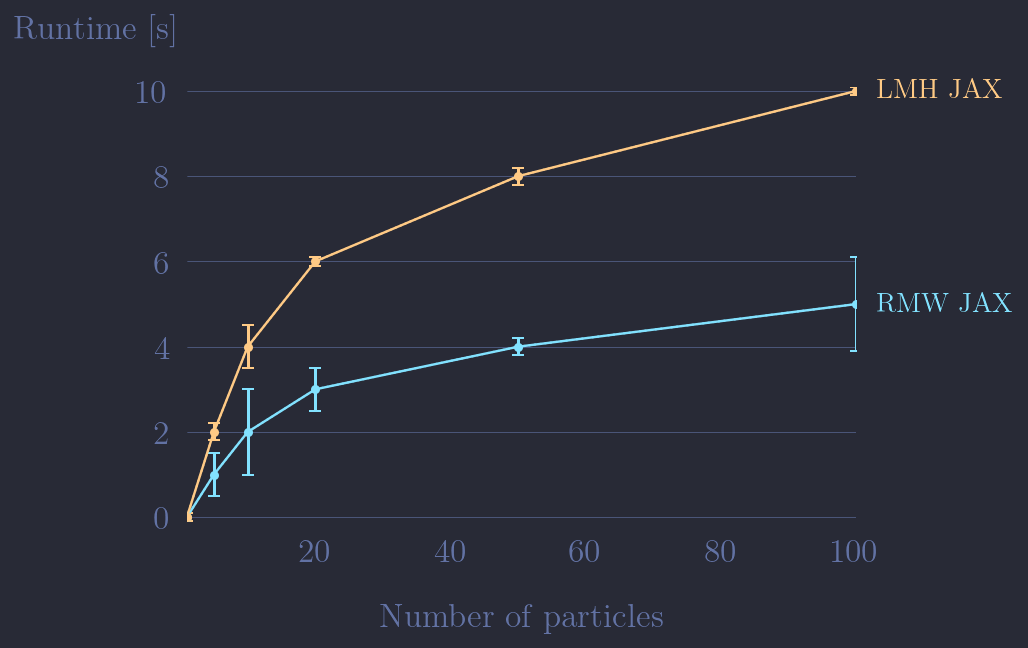

In [7]:
dataset = {"t": [i for i in range(6)], "N_particles":[1, 5, 10, 20, 50, 100], "sigma": [0.1, 0.5, 1.0, 0.5, 0.2, 1.1]}
dataset2 = {"t": [2*i for i in range(6)], "N_particles":[1, 5, 10, 20, 50, 100], "sigma": [0.1, 0.2, 0.5, 0.1, 0.2, 0.1]}
datasets = [pd.DataFrame(data=dataset), pd.DataFrame(data=dataset2)]
plot_(datasets, ["RMW JAX", "LMH JAX"], "Number of particles", "Runtime [s]", ["N_particles", "t", "sigma"])

In [8]:
N = 10
dim = 3
omega = 1.0
initial_alpha = 0.5
wf = vmc.AEHOIB(N, dim, omega, a=0) # setting a=0, such that the bosons are point particles
sampler = vmc.Metropolis(wf)
nsamples = int(2**16)
initial_positions, scale = interact_initial_positions(wf, initial_alpha, N, dim)
start = time.time()
results = sampler.sample(nsamples, 
                        initial_positions, 
                        initial_alpha, 
                        nchains=1,
                        scale=1.0, 
                        warm=True, 
                        warmup_iter=20000, 
                        tune=True, 
                        tune_iter=30000, 
                        tune_interval=1000,
                        optimize=False,
                        max_iter=200000,
                        batch_size=2000,
                        gradient_method='adam',
                        eta=0.01,
                        tol_optim=1e-7,
                        )
end = time.time()
print("Sampler elapsed time:", end - start)
print(results)

wf = vmc.EHONIB()
initial_positions, scale = interact_initial_positions(wf, initial_alpha, N, dim)
start = time.time()
results_JAX = sampler.sample(nsamples, 
                            initial_positions, 
                            initial_alpha, 
                            nchains=1,
                            scale=1.0, 
                            warm=True, 
                            warmup_iter=20000, 
                            tune=True, 
                            tune_iter=30000, 
                            tune_interval=1000,
                            optimize=False,
                            max_iter=200000,
                            batch_size=2000,
                            gradient_method='adam',
                            eta=0.01,
                            tol_optim=1e-7,
                            )
end = time.time()
print("Sampler elapsed time:", end - start)
print(results_JAX)

Warm done
Tune done
Warm after tune done
Rewarming done
Sampling energy
Sampler elapsed time: 53.878594398498535
   nparticles  dim  alpha    energy  standard_error  accept_rate
0          10    3    0.5  24.14215             0.0     0.323944
Warm done
Tune done
Warm after tune done
Rewarming done
Sampling energy
Sampler elapsed time: 52.61825752258301
   nparticles  dim  alpha    energy  standard_error  accept_rate
0          10    3    0.5  24.14215             0.0     0.371506


#### Small analysis
$\alpha=0.5$ corresponds to the ground state for non-interacting particles. The ground state energy per particle is $\langle E\rangle/N = 2.414215$. 

## Interacting particles in elliptical potential

In [7]:
N = 10
dim = 3
omega = 1.0
initial_alpha = 0.5
wf = vmc.AEHOIB(N, dim, omega)
sampler = vmc.Metropolis(wf)
nsamples = int(2**15)
initial_positions, scale = interact_initial_positions(wf, initial_alpha, N, dim)
results_E10 = []
start = time.time()
results_E10 = sampler.sample(nsamples, 
                             initial_positions, 
                             initial_alpha, 
                             nchains=16,
                             scale=1.0, 
                             warm=True, 
                             warmup_iter=20000, 
                             tune=True, 
                             tune_iter=30000, 
                             tune_interval=1000,
                             optimize=False,
                             max_iter=400000,
                             batch_size=5000,
                             gradient_method='adam',
                             eta=0.01,
                            tol_optim=1e-8,
                            )
end = time.time()
print("Sampler elapsed time:", end - start)
df_N10_all = sampler.results_all
df_N10 = results_E10

Sampler elapsed time: 71.01043963432312


In [19]:
energy_mean = df_N10["energy"].mean()
error_mean = df_N10["standard_error"].mean()
alpha_mean = df_N10["alpha"].mean()
alpha_std = df_N10["alpha"].std()
print(f"VMC energy: {energy_mean}")
print(f"VMC error: {error_mean}")
print(f"VMC optimal alpha: {alpha_mean}+-{alpha_std}")

VMC energy: 24.45972859507188
VMC error: 0.0005365271684803576
VMC optimal alpha: 0.49967474881599716+-0.001055636691325557


In [17]:
df_N10_all

,nparticles,dim,scale,eta,alpha,energy,standard_error,accept_rate,nsamples,total_cycles,warmup_cycles,tuning_cycles,optimize_cycles
0,10,3,0.250000,0.1,0.498827,24.442265,0.000406,0.249551,1048576,1516576,533000,3000,380000
1,10,3,0.194872,0.1,0.499132,24.471879,0.000424,0.380171,1048576,1522576,545000,3000,380000
2,10,3,0.214359,0.1,0.497556,24.460220,0.000507,0.331434,1048576,1525576,551000,3000,380000
3,10,3,0.214359,0.1,0.499269,24.459964,0.000429,0.328551,1048576,1523576,547000,3000,380000


NameError: name 'df_N10' is not defined

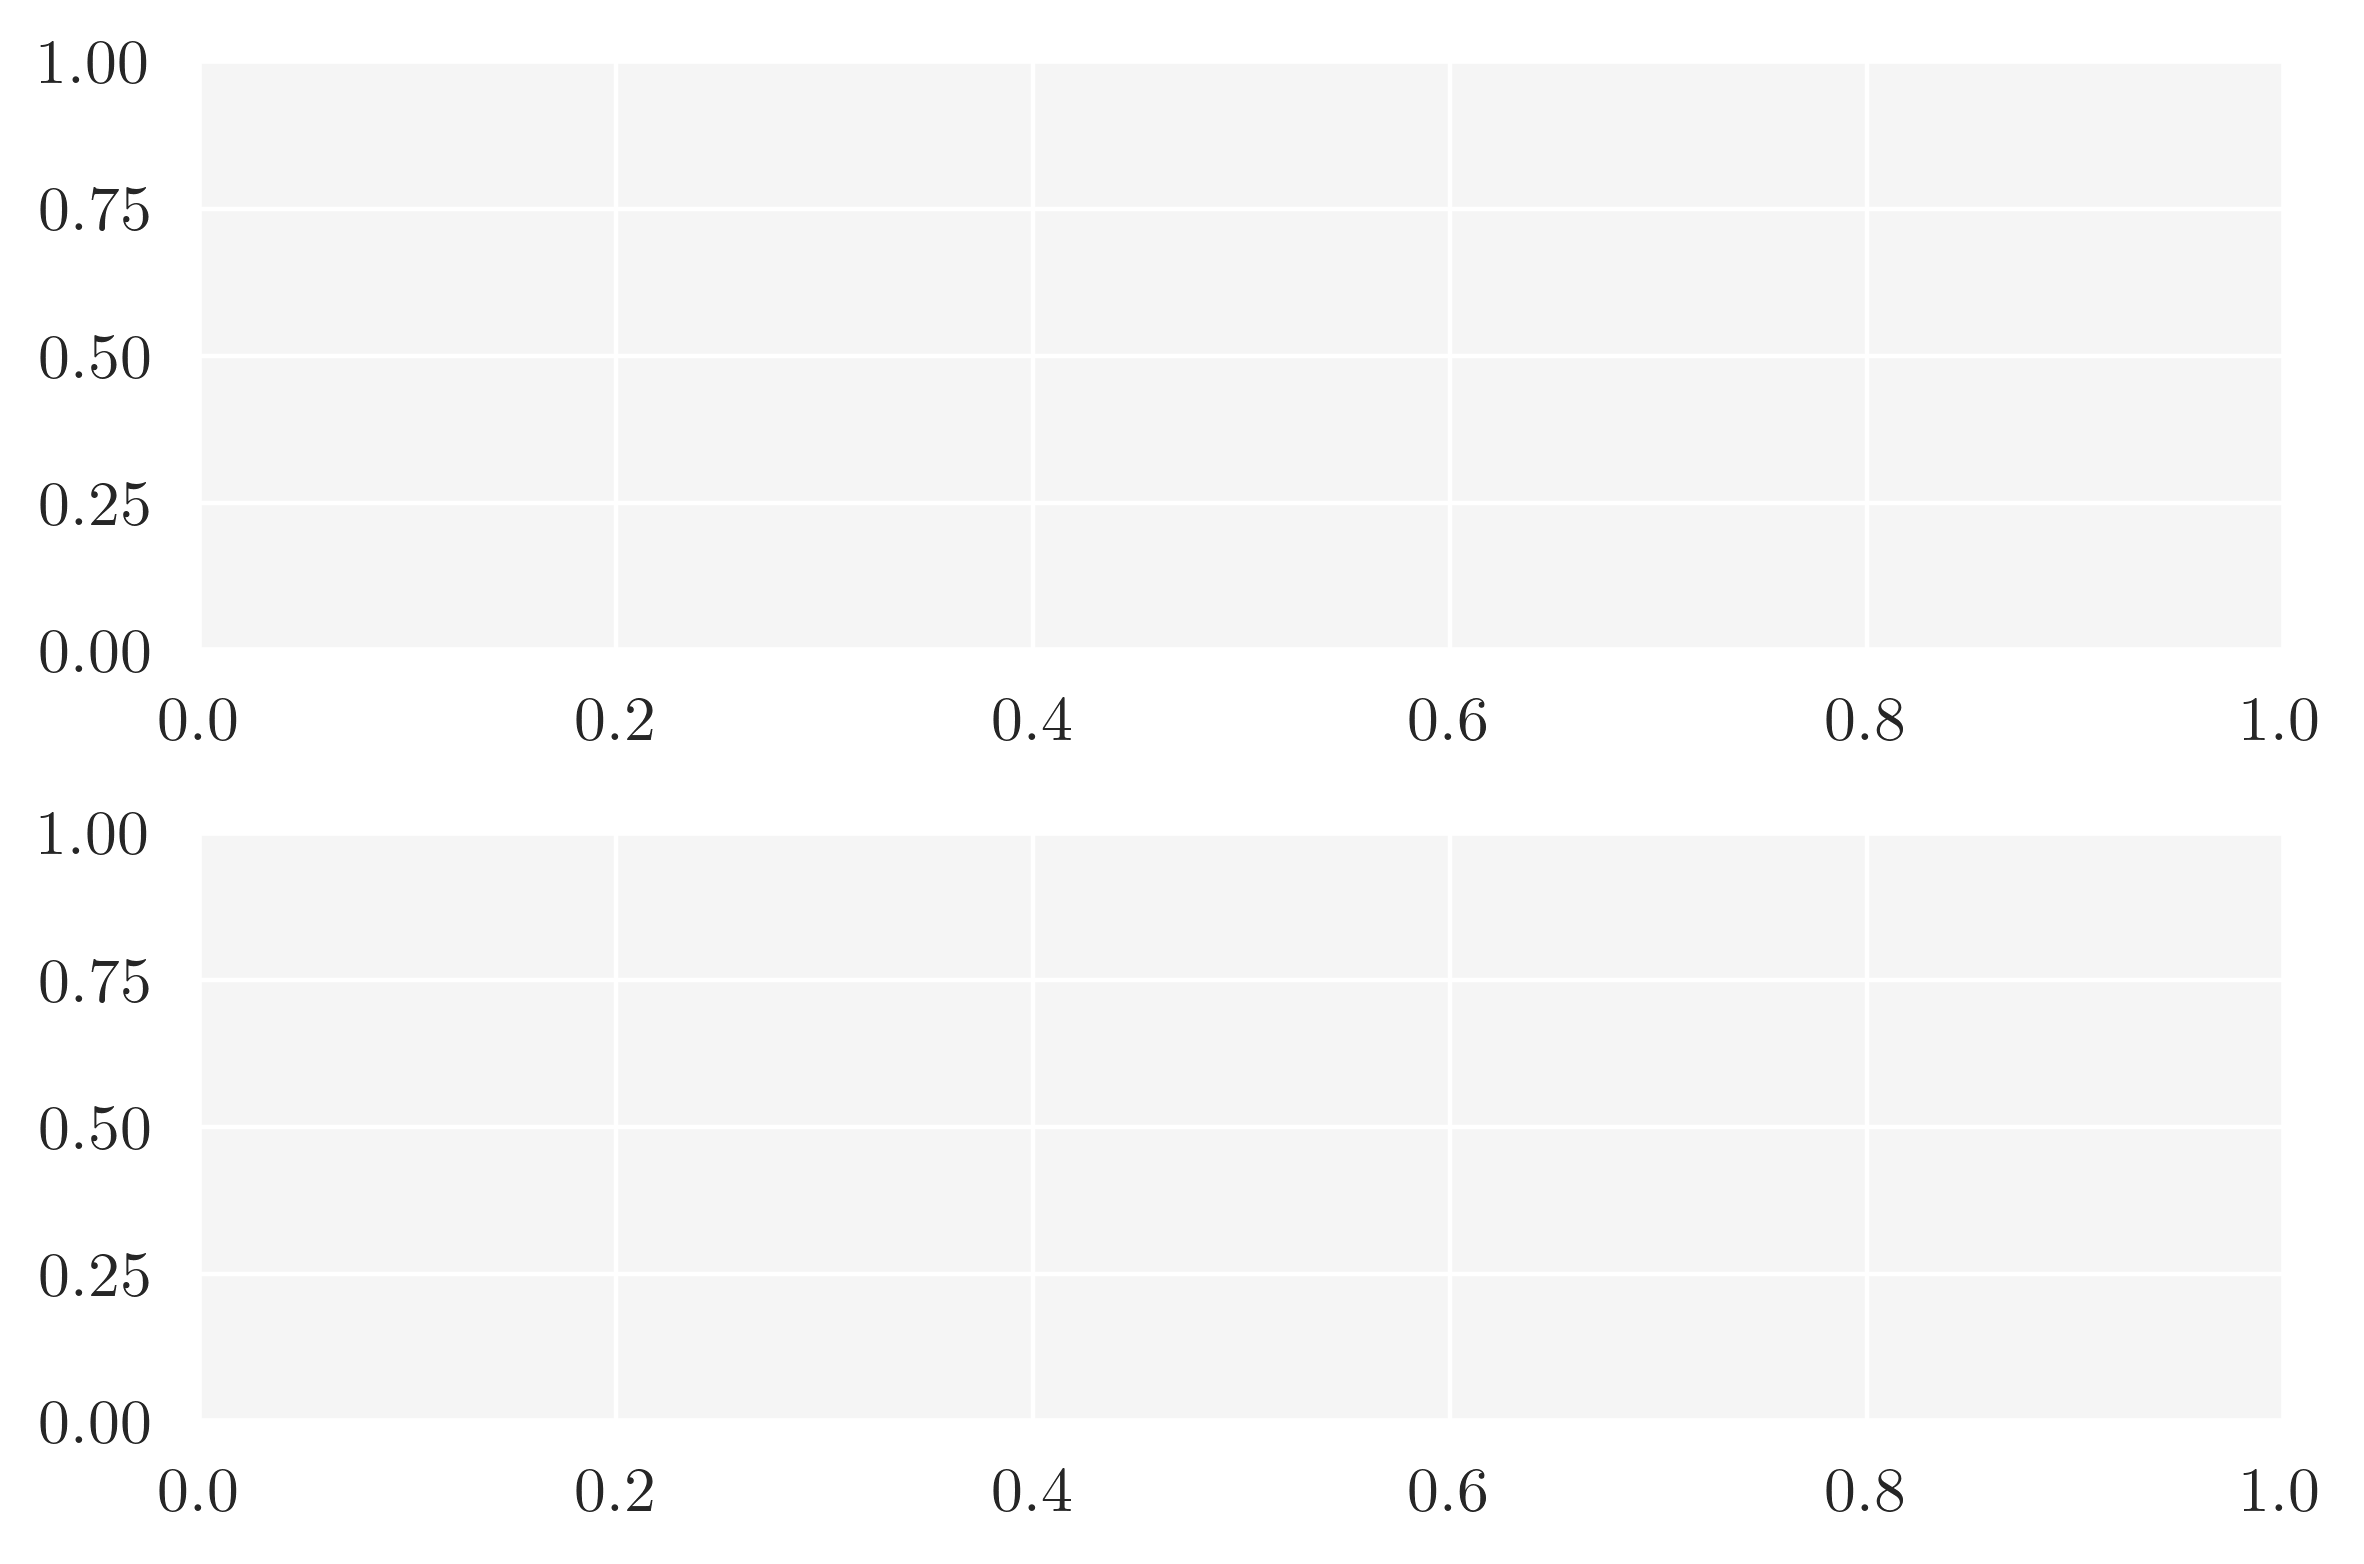

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 4), tight_layout=True, dpi=200)

sns.boxplot(data=df_N10, x="energy", color="C0", fliersize=0, ax=axes[0])
sns.swarmplot(data=df_N10, x="energy", color=".25", ax=axes[0])
axes[0].set(xlabel="Energy")

sns.boxplot(data=df_N10, x="standard_error", color="C1", fliersize=0, ax=axes[1])
sns.swarmplot(data=df_N10, x="standard_error", color=".25", ax=axes[1])
axes[1].set(xlabel="Standard Error")

fig.savefig(fig_path("boxplot_E_N10_metropolis.pdf"), bbox_inches='tight')
sns.despine()
plt.show()

In [21]:
N = 50
dim = 3
omega = 1.0
initial_alpha = 0.5
wf = vmc.AEHOIB(N, dim, omega)
sampler = vmc.Metropolis(wf)
nsamples = int(2**18)
initial_positions, scale = interact_initial_positions(wf, initial_alpha, N, dim)
start = time.time()
results = sampler.sample(nsamples, 
                        initial_positions, 
                        initial_alpha, 
                        nchains=16,
                        scale=1.0, 
                        warm=True, 
                        warmup_iter=20000, 
                        tune=True, 
                        tune_iter=30000, 
                        tune_interval=1000,
                        optimize=True,
                        max_iter=500000,
                        batch_size=2000,
                        gradient_method='adam',
                        eta=0.01,
                        tol_optim=1e-8,
                        )
end = time.time()
print("Sampler elapsed time:", end - start)
print(results)

Sampler elapsed time: 1987.2253048419952
   nparticles  dim     alpha      energy  standard_error  accept_rate
0          50    3  0.512692  128.641933        0.044726     0.313393
1          50    3  0.501411  128.321151        0.014859     0.270054
2          50    3  0.498878  128.507781        0.015417     0.326302
3          50    3  0.492616  128.557249        0.024056     0.321404


In [22]:
df_N50 = pd.DataFrame(data=results)
energy_mean = df_N50["energy"].mean()
error_mean = df_N50["standard_error"].mean()
alpha_mean = df_N50["alpha"].mean()
alpha_std = df_N50["alpha"].std()
print(f"VMC energy: {energy_mean}")
print(f"VMC error: {error_mean}")
print(f"VMC optimal alpha: {alpha_mean}+-{alpha_std}")

VMC energy: 128.50702834128964
VMC error: 0.024764523181279568
VMC optimal alpha: 0.5013989559448111+-0.008387089130498104


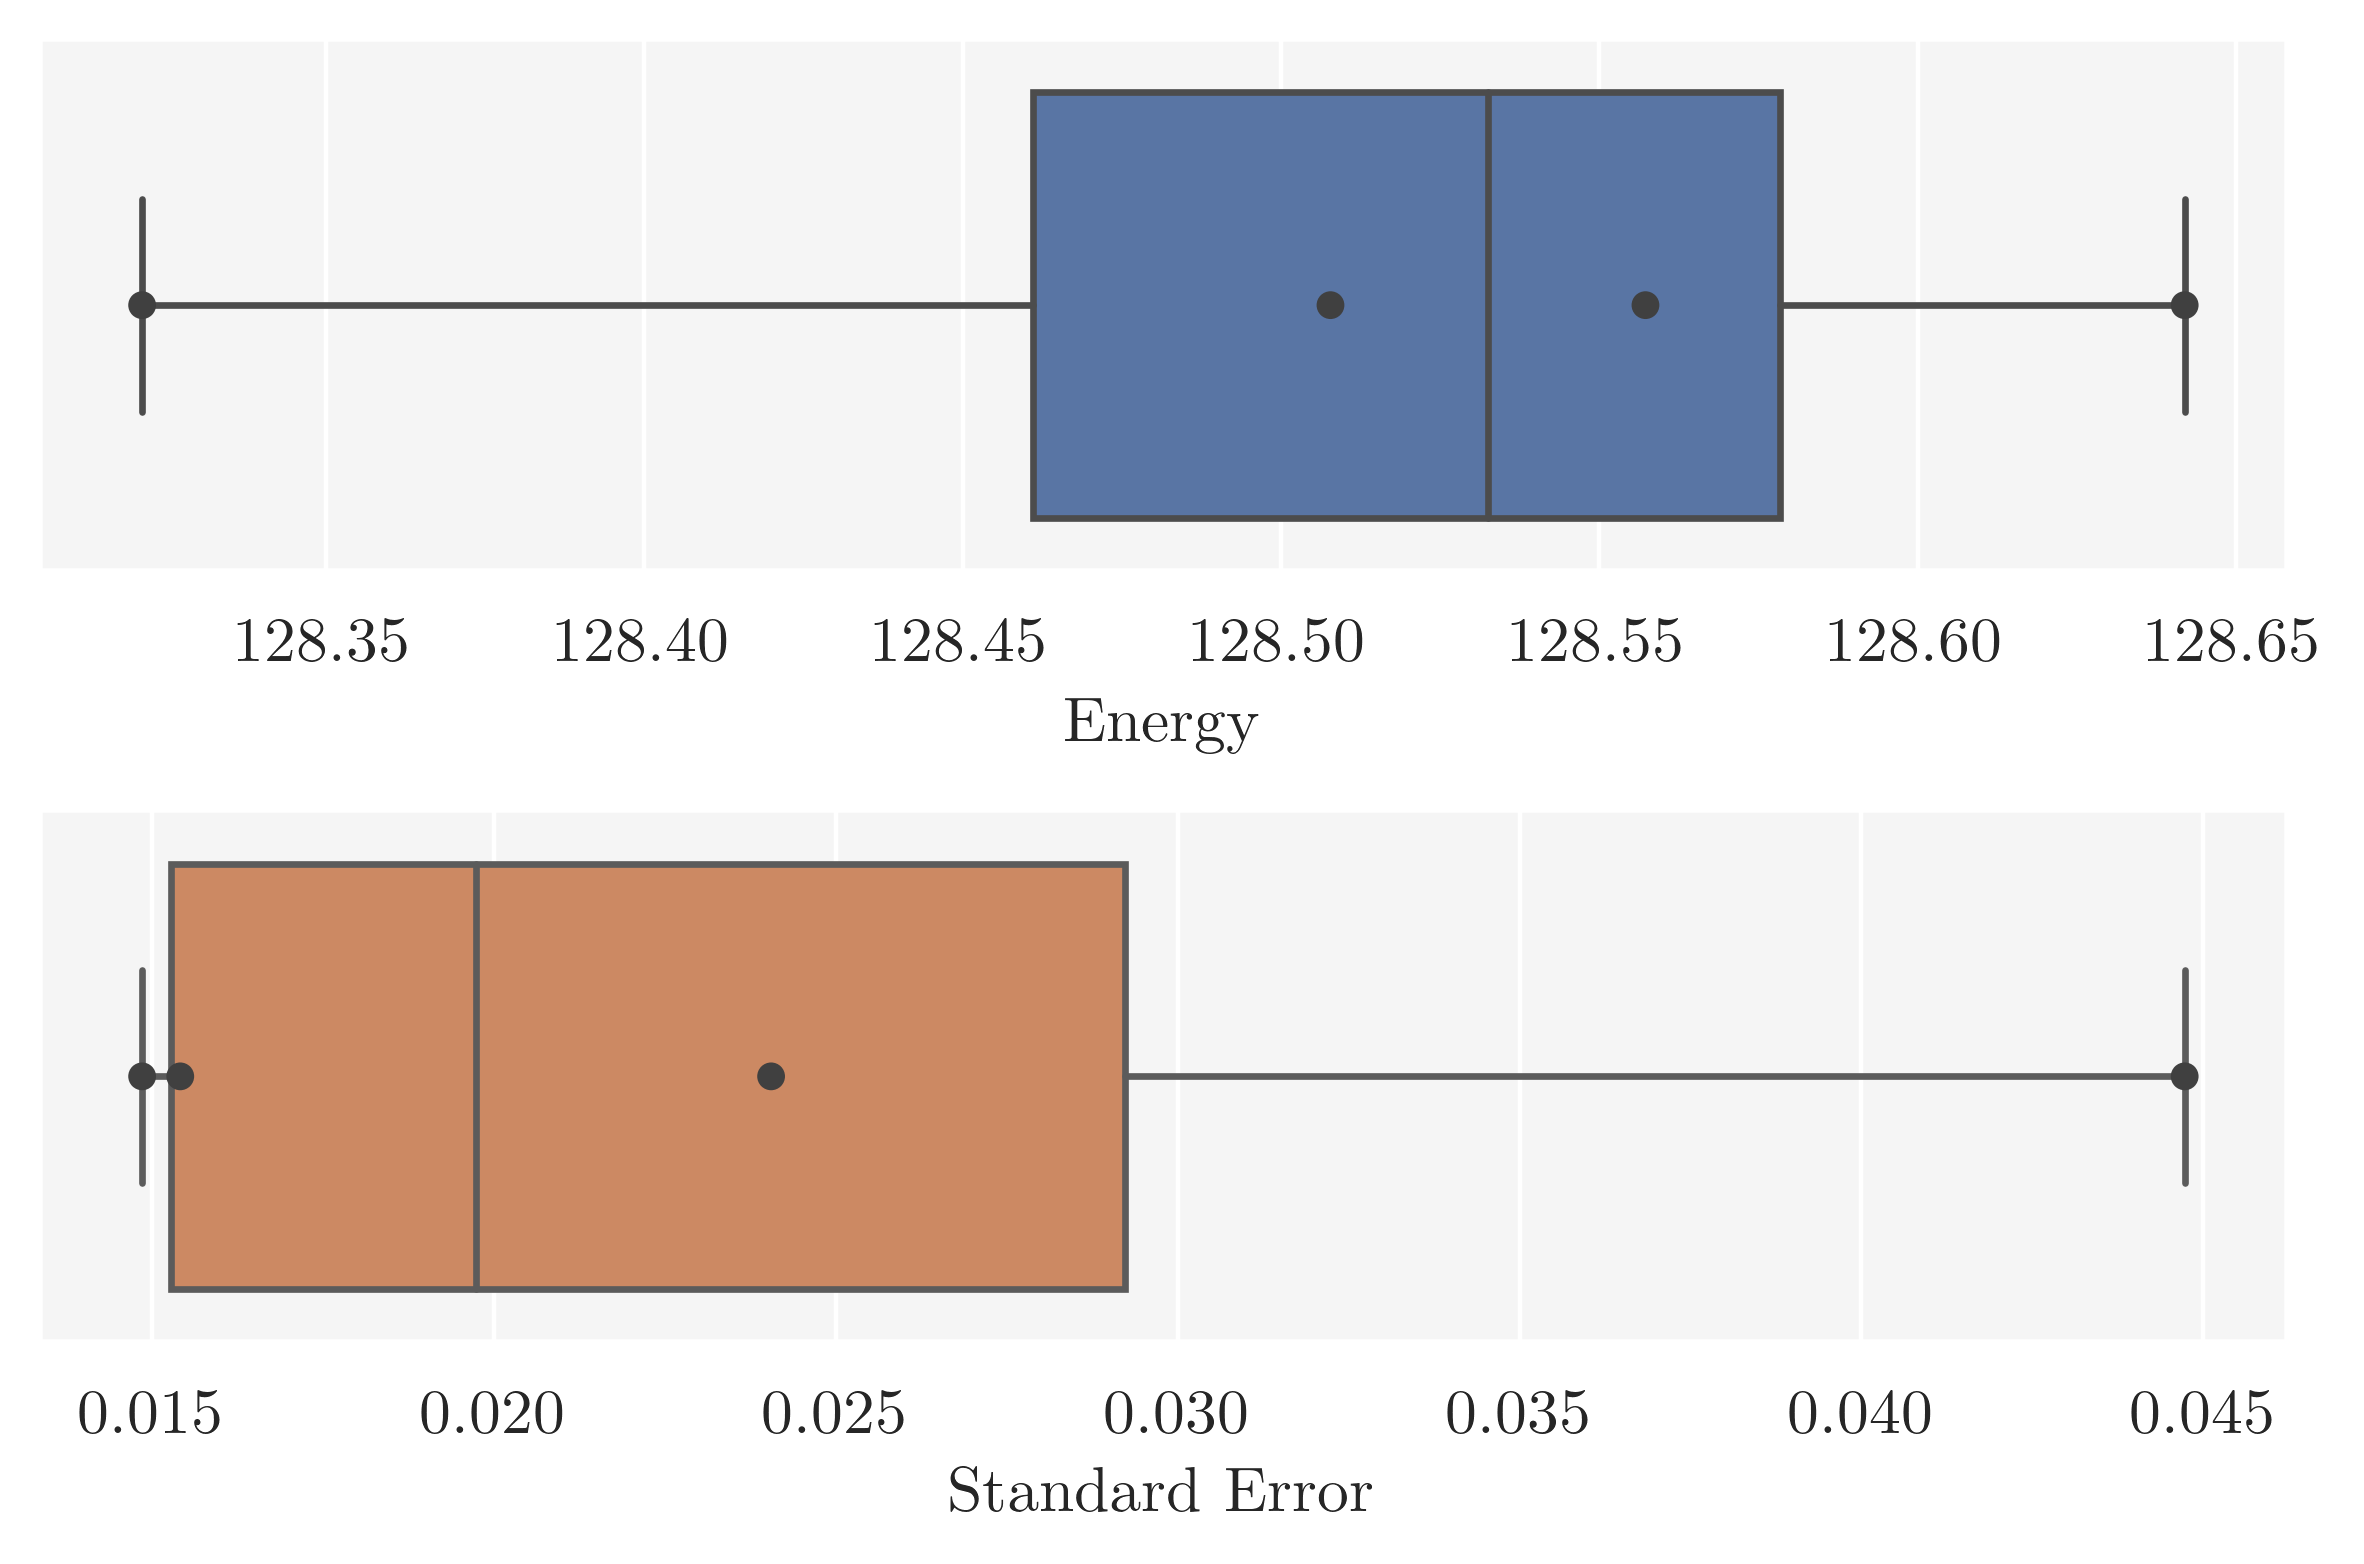

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 4), tight_layout=True, dpi=200)

sns.boxplot(data=df_N50, x="energy", color="C0", fliersize=0, ax=axes[0])
sns.swarmplot(data=df_N50, x="energy", color=".25", ax=axes[0])
axes[0].set(xlabel="Energy")

sns.boxplot(data=df_N50, x="standard_error", color="C1", fliersize=0, ax=axes[1])
sns.swarmplot(data=df_N50, x="standard_error", color=".25", ax=axes[1])
axes[1].set(xlabel="Standard Error")

fig.savefig(fig_path("boxplot_E_N50_metropolis.pdf"), bbox_inches='tight')

plt.show()

In [ ]:
N = 100
dim = 3
omega = 1.0
initial_alpha = 0.5
wf = vmc.AEHOIB(N, dim, omega)
sampler = vmc.Metropolis(wf)
nsamples = int(2**18)
initial_positions, scale = interact_initial_positions(wf, initial_alpha, N, dim)
start = time.time()
results = sampler.sample(nsamples, 
                        initial_positions, 
                        initial_alpha, 
                        nchains=4,
                        scale=1.0, 
                        warm=True, 
                        warmup_iter=20000, 
                        tune=True, 
                        tune_iter=30000, 
                        tune_interval=1000,
                        optimize=True,
                        max_iter=200000,
                        batch_size=2000,
                        gradient_method='adam',
                        eta=0.1,
                        tol_optim=1e-7,
                        )
end = time.time()
print("Sampler elapsed time:", end - start)
print(results)

## RMW vs LMH elliptical interacting

In [5]:
N = 10 
dim = 3 
omega = 1.0
alpha = 0.49967474881599716 # Alpha fra optimize
nchains = 4
wf = vmc.AEHOIB(N, dim, omega)
sampler = vmc.Metropolis(wf)
initial_positions, scale = interact_initial_positions(wf, alpha, N, dim)
results=[]
times_RWM = []
for i in range(10, 20, 1): 
    nsamples = int(2**i)
    start = time.time()
    result = sampler.sample(nsamples, 
                            initial_positions, 
                            alpha, 
                            nchains=nchains,
                            scale=1.0,
                            warm=True,
                            warmup_iter=20000,
                            tune=True, 
                            tune_iter=30000, 
                            tune_interval=1000,
                            optimize=False,
                            )
    print(result)
    end = time.time()
    print("Sampler time: ", end-start)
    times_RWM.append(end-start)
    results.append(result)
    
df_N10_RWM = pd.concat(results, ignore_index=True)
df_N10_RWM

   nparticles  dim     alpha     energy  standard_error  accept_rate
0          10    3  0.499675  24.435773        0.007136     0.233398
1          10    3  0.499675  24.459446        0.011797     0.334961
2          10    3  0.499675  24.457214        0.008299     0.382812
3          10    3  0.499675  24.460239        0.005868     0.366211
Sampler time:  37.40209722518921
   nparticles  dim     alpha     energy  standard_error  accept_rate
0          10    3  0.499675  24.461389        0.007101     0.378906
1          10    3  0.499675  24.445339        0.007473     0.237793
2          10    3  0.499675  24.475389        0.007573     0.406250
3          10    3  0.499675  24.445380        0.005885     0.344727
Sampler time:  46.17709040641785
   nparticles  dim     alpha     energy  standard_error  accept_rate
0          10    3  0.499675  24.450747        0.006930     0.247803
1          10    3  0.499675  24.446993        0.005728     0.311523
2          10    3  0.499675  24.4705

,nparticles,dim,alpha,energy,standard_error,accept_rate
0,10,3,0.499675,24.435773,0.007136,0.233398
1,10,3,0.499675,24.459446,0.011797,0.334961
2,10,3,0.499675,24.457214,0.008299,0.382812
3,10,3,0.499675,24.460239,0.005868,0.366211
4,10,3,0.499675,24.461389,0.007101,0.378906
5,10,3,0.499675,24.445339,0.007473,0.237793
6,10,3,0.499675,24.475389,0.007573,0.406250
7,10,3,0.499675,24.445380,0.005885,0.344727
8,10,3,0.499675,24.450747,0.006930,0.247803
9,10,3,0.499675,24.446993,0.005728,0.311523


In [7]:
analysis_RWM = {"nsamples":[], "mean_energy":[], "standard_error": [], "sampling_time": times_RWM}
for i in range(10, 20, 1): 
    analysis_RWM["nsamples"].append(int(i))
    analysis_RWM["mean_energy"].append(np.mean(df_N10_RWM["energy"][i:i+nchains]))
    analysis_RWM["standard_error"].append(np.mean(df_N10_RWM["standard_error"][i:i+nchains]))
    
analysis_data_RWM = pd.DataFrame(data=analysis_RWM)
analysis_data_RWM

,nsamples,mean_energy,standard_error,sampling_time
0,10,24.466158,0.005191,37.402097
1,11,24.466587,0.004468,46.177090
2,12,24.467230,0.004031,50.805288
3,13,24.464203,0.003817,62.537370
4,14,24.457431,0.003403,73.500987
5,15,24.456252,0.003163,98.453155
6,16,24.460191,0.002863,146.371111
7,17,24.464494,0.002675,218.100257
8,18,24.467769,0.002607,396.180344
9,19,24.465439,0.002422,703.036992


In [10]:
N = 10 
dim = 3 
omega = 1.0
alpha = 0.49967474881599716
nchains = 4
wf = vmc.AEHOIB(N, dim, omega)
sampler = vmc.MetropolisHastings(wf)
initial_positions, scale = interact_initial_positions(wf, alpha, N, dim)
results=[]
times_LMH = []
for i in range(10, 20, 1): 
    nsamples = int(2**i)
    start = time.time()
    result = sampler.sample(nsamples, 
                            initial_positions, 
                            alpha, 
                            nchains=nchains,
                            dt=0.01,
                            warm=True,
                            warmup_iter=20000,
                            tune=True, 
                            tune_iter=30000, 
                            tune_interval=1000,
                            optimize=False,
                            )
    end = time.time()
    print(result)
    print("Sampler elapsed time: ", end-start)
    times_LMH.append(end-start)
    results.append(result)
    
df_N10_LMH = pd.concat(results, ignore_index=True)
df_N10_LMH

   nparticles  dim     alpha     energy  standard_error  accept_rate
0          10    3  0.499675  24.442386        0.006288     0.710938
1          10    3  0.499675  24.448930        0.006327     0.783203
2          10    3  0.499675  24.459456        0.007431     0.794922
3          10    3  0.499675  24.471092        0.006247     0.801758
Sampler elapsed time:  86.33092617988586
   nparticles  dim     alpha     energy  standard_error  accept_rate
0          10    3  0.499675  24.444063        0.005586     0.750977
1          10    3  0.499675  24.462668        0.004864     0.799805
2          10    3  0.499675  24.474654        0.005873     0.799316
3          10    3  0.499675  24.469470        0.005940     0.794922
Sampler elapsed time:  94.23025918006897
   nparticles  dim     alpha     energy  standard_error  accept_rate
0          10    3  0.499675  24.460514        0.003545     0.799805
1          10    3  0.499675  24.445628        0.003674     0.717041
2          10    3  0

,nparticles,dim,alpha,energy,standard_error,accept_rate
0,10,3,0.499675,24.442386,0.006288,0.710938
1,10,3,0.499675,24.448930,0.006327,0.783203
2,10,3,0.499675,24.459456,0.007431,0.794922
3,10,3,0.499675,24.471092,0.006247,0.801758
4,10,3,0.499675,24.444063,0.005586,0.750977
5,10,3,0.499675,24.462668,0.004864,0.799805
6,10,3,0.499675,24.474654,0.005873,0.799316
7,10,3,0.499675,24.469470,0.005940,0.794922
8,10,3,0.499675,24.460514,0.003545,0.799805
9,10,3,0.499675,24.445628,0.003674,0.717041


In [11]:
nchains=4
analysis_LMH = {"nsamples":[], "mean_energy":[], "standard_error": [], "sampling_time":times_LMH}
for i in range(10, 20, 1): 
    analysis_LMH["nsamples"].append(int(i))
    analysis_LMH["mean_energy"].append(np.mean(df_N10_LMH["energy"][i:i+nchains]))
    analysis_LMH["standard_error"].append(np.mean(df_N10_LMH["standard_error"][i:i+nchains]))
    
analysis_data_LMH = pd.DataFrame(data=analysis_LMH)
analysis_data_LMH

,nsamples,mean_energy,standard_error,sampling_time
0,10,24.452249,0.003207,86.330926
1,11,24.453027,0.003018,94.230259
2,12,24.458134,0.002788,98.358985
3,13,24.462548,0.002594,117.685274
4,14,24.463433,0.002453,127.448751
5,15,24.464063,0.002317,154.185898
6,16,24.464231,0.002168,231.951024
7,17,24.465265,0.002053,351.766606
8,18,24.466461,0.001942,625.540365
9,19,24.461696,0.001717,1160.538835


NameError: name 'analysis_data_RWM' is not defined

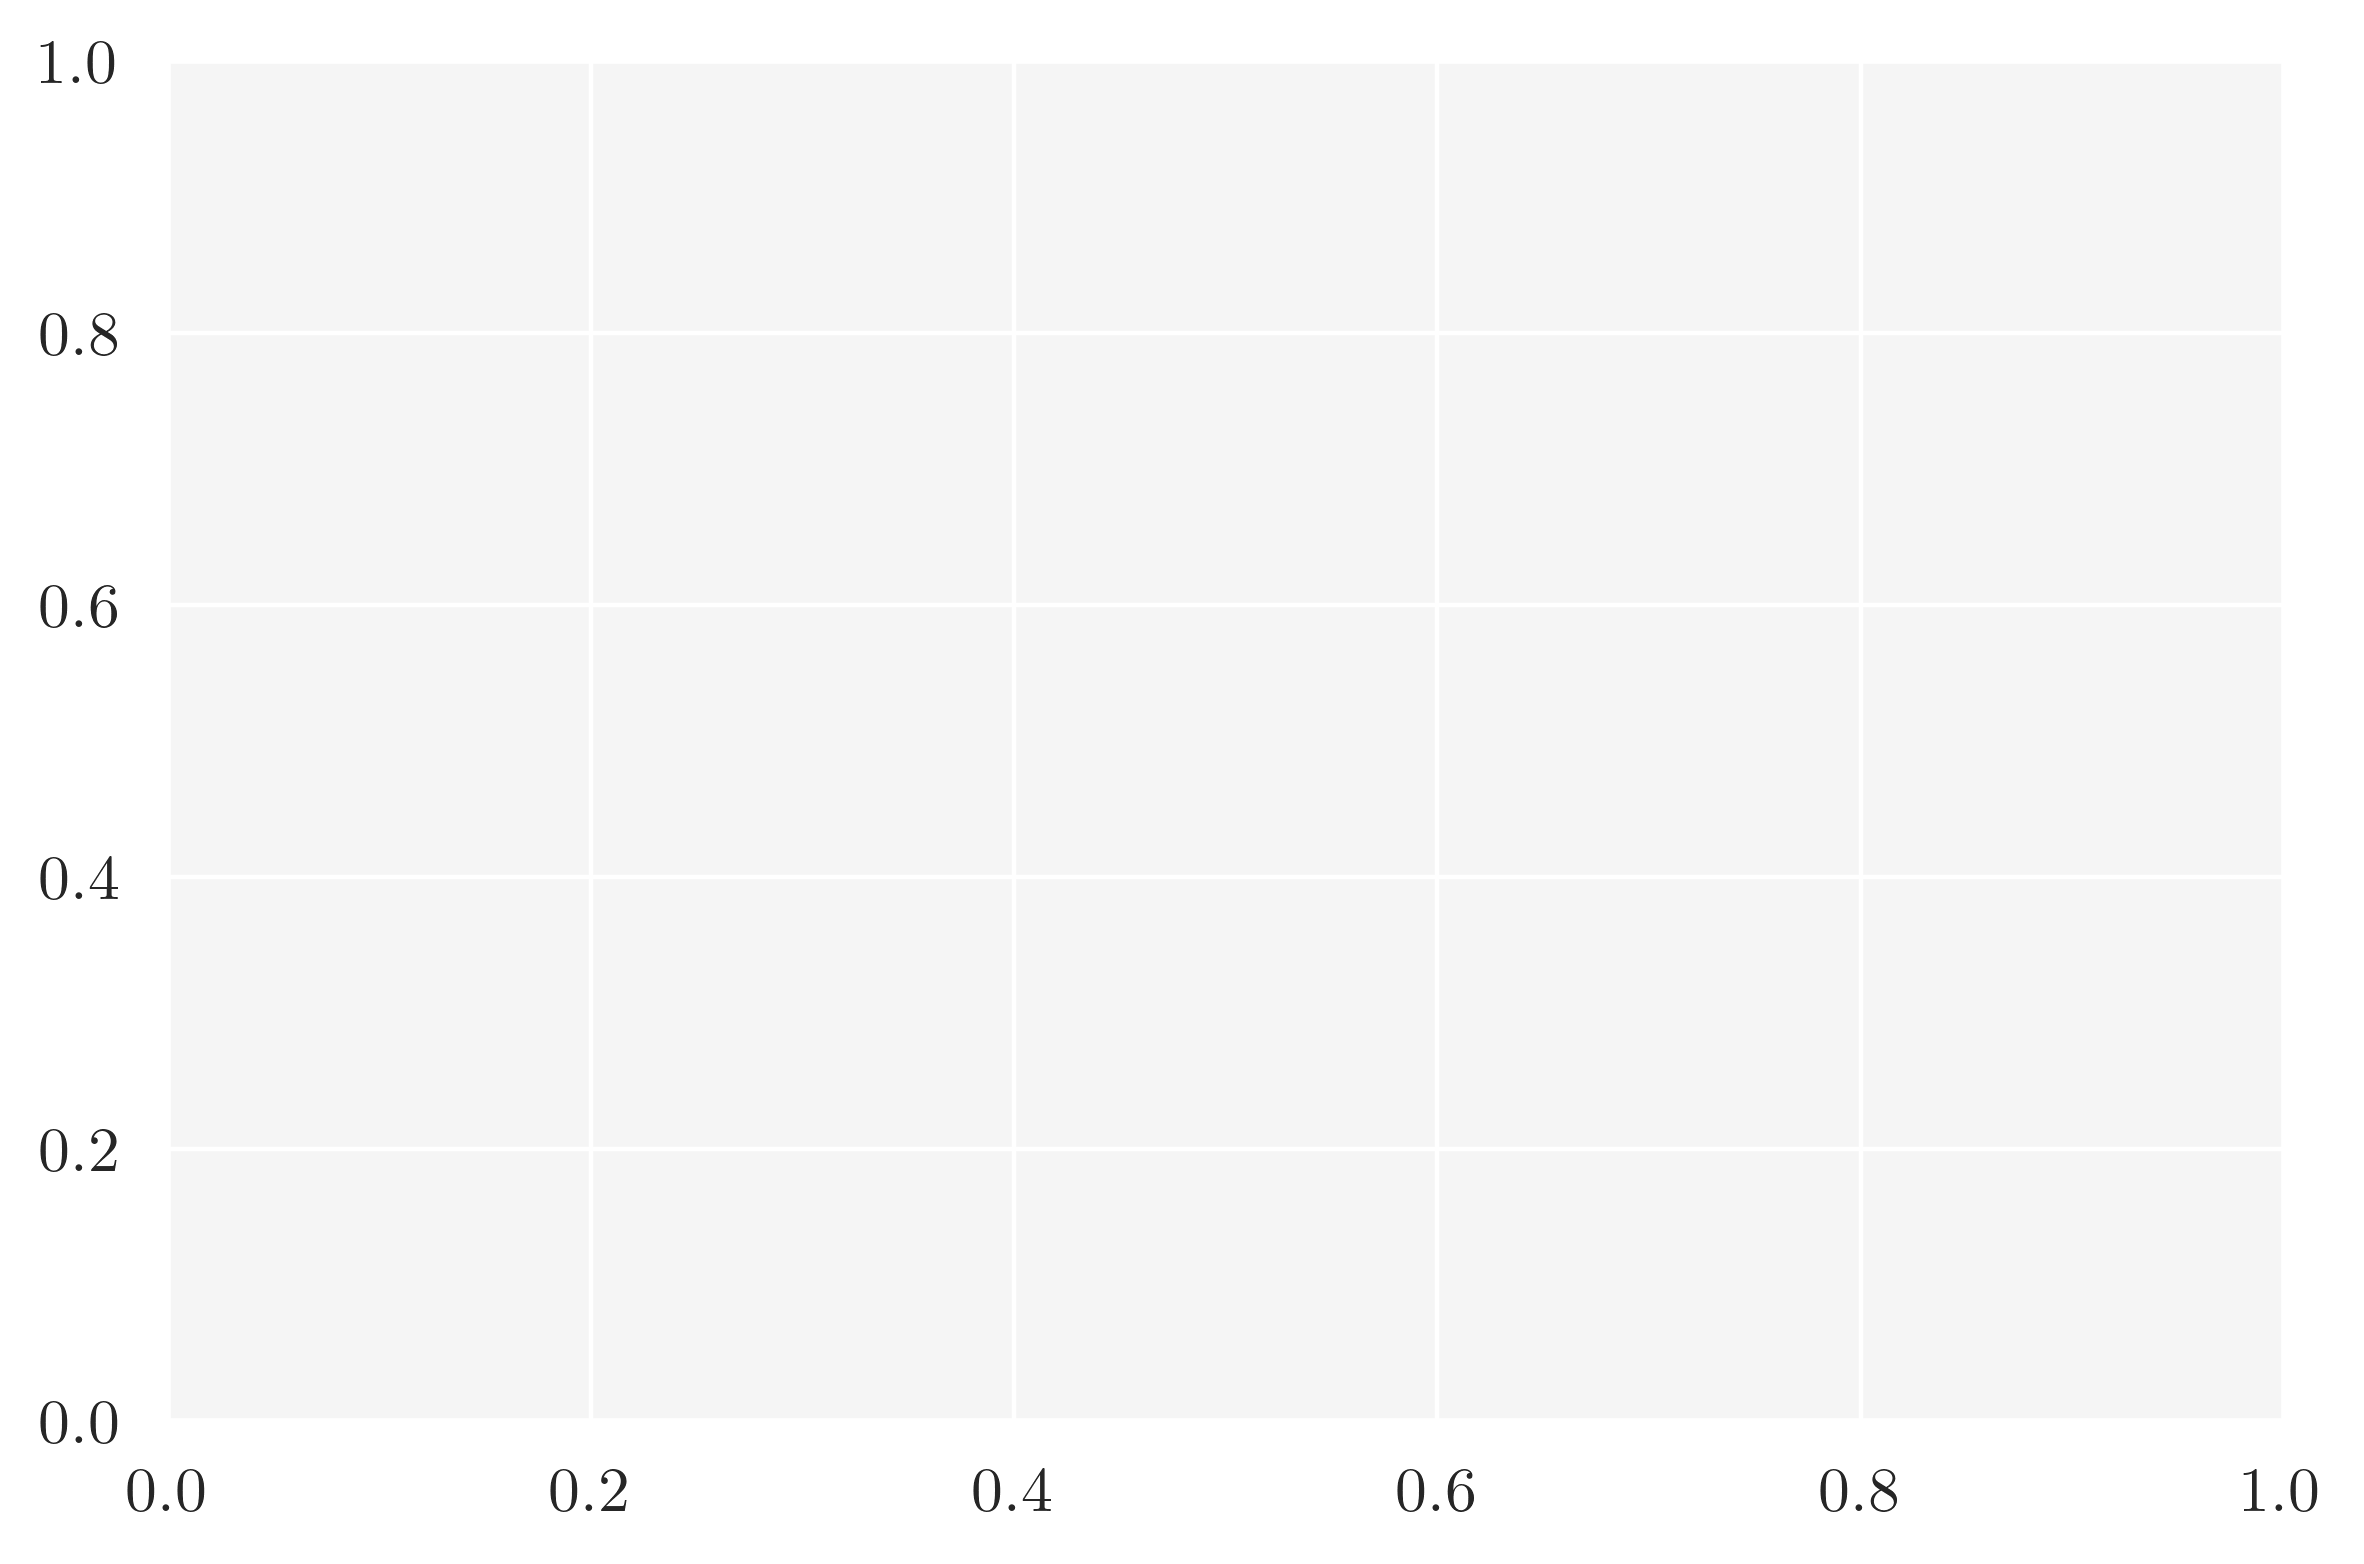

In [94]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
sns.lineplot(data=analysis_data_RWM, x="nsamples", y="standard_error", ax=ax, label=r'$\sigma$ RWM')
sns.lineplot(data=analysis_data_LMH, x="nsamples", y="standard_error", ax=ax, label=r'$\sigma$ LMH')
tex_xlabel = '\n'.join((r'$\log_2{M}$',
                      'Number of MCMC samples'))
tex_ylabel = '\n'.join(('Standard error',
                        r'$\sigma (\hbar\omega_0)$'))
ax.set(xlabel=tex_xlabel, ylabel=tex_ylabel)
#ax.set_xticks(analysis_data_RMW["nsamples"])
#ax.set_xticklabels()
ax.legend()
fig.savefig(fig_path("Error_comparison_RMW_LMH.pdf"), bbox_inches='tight')

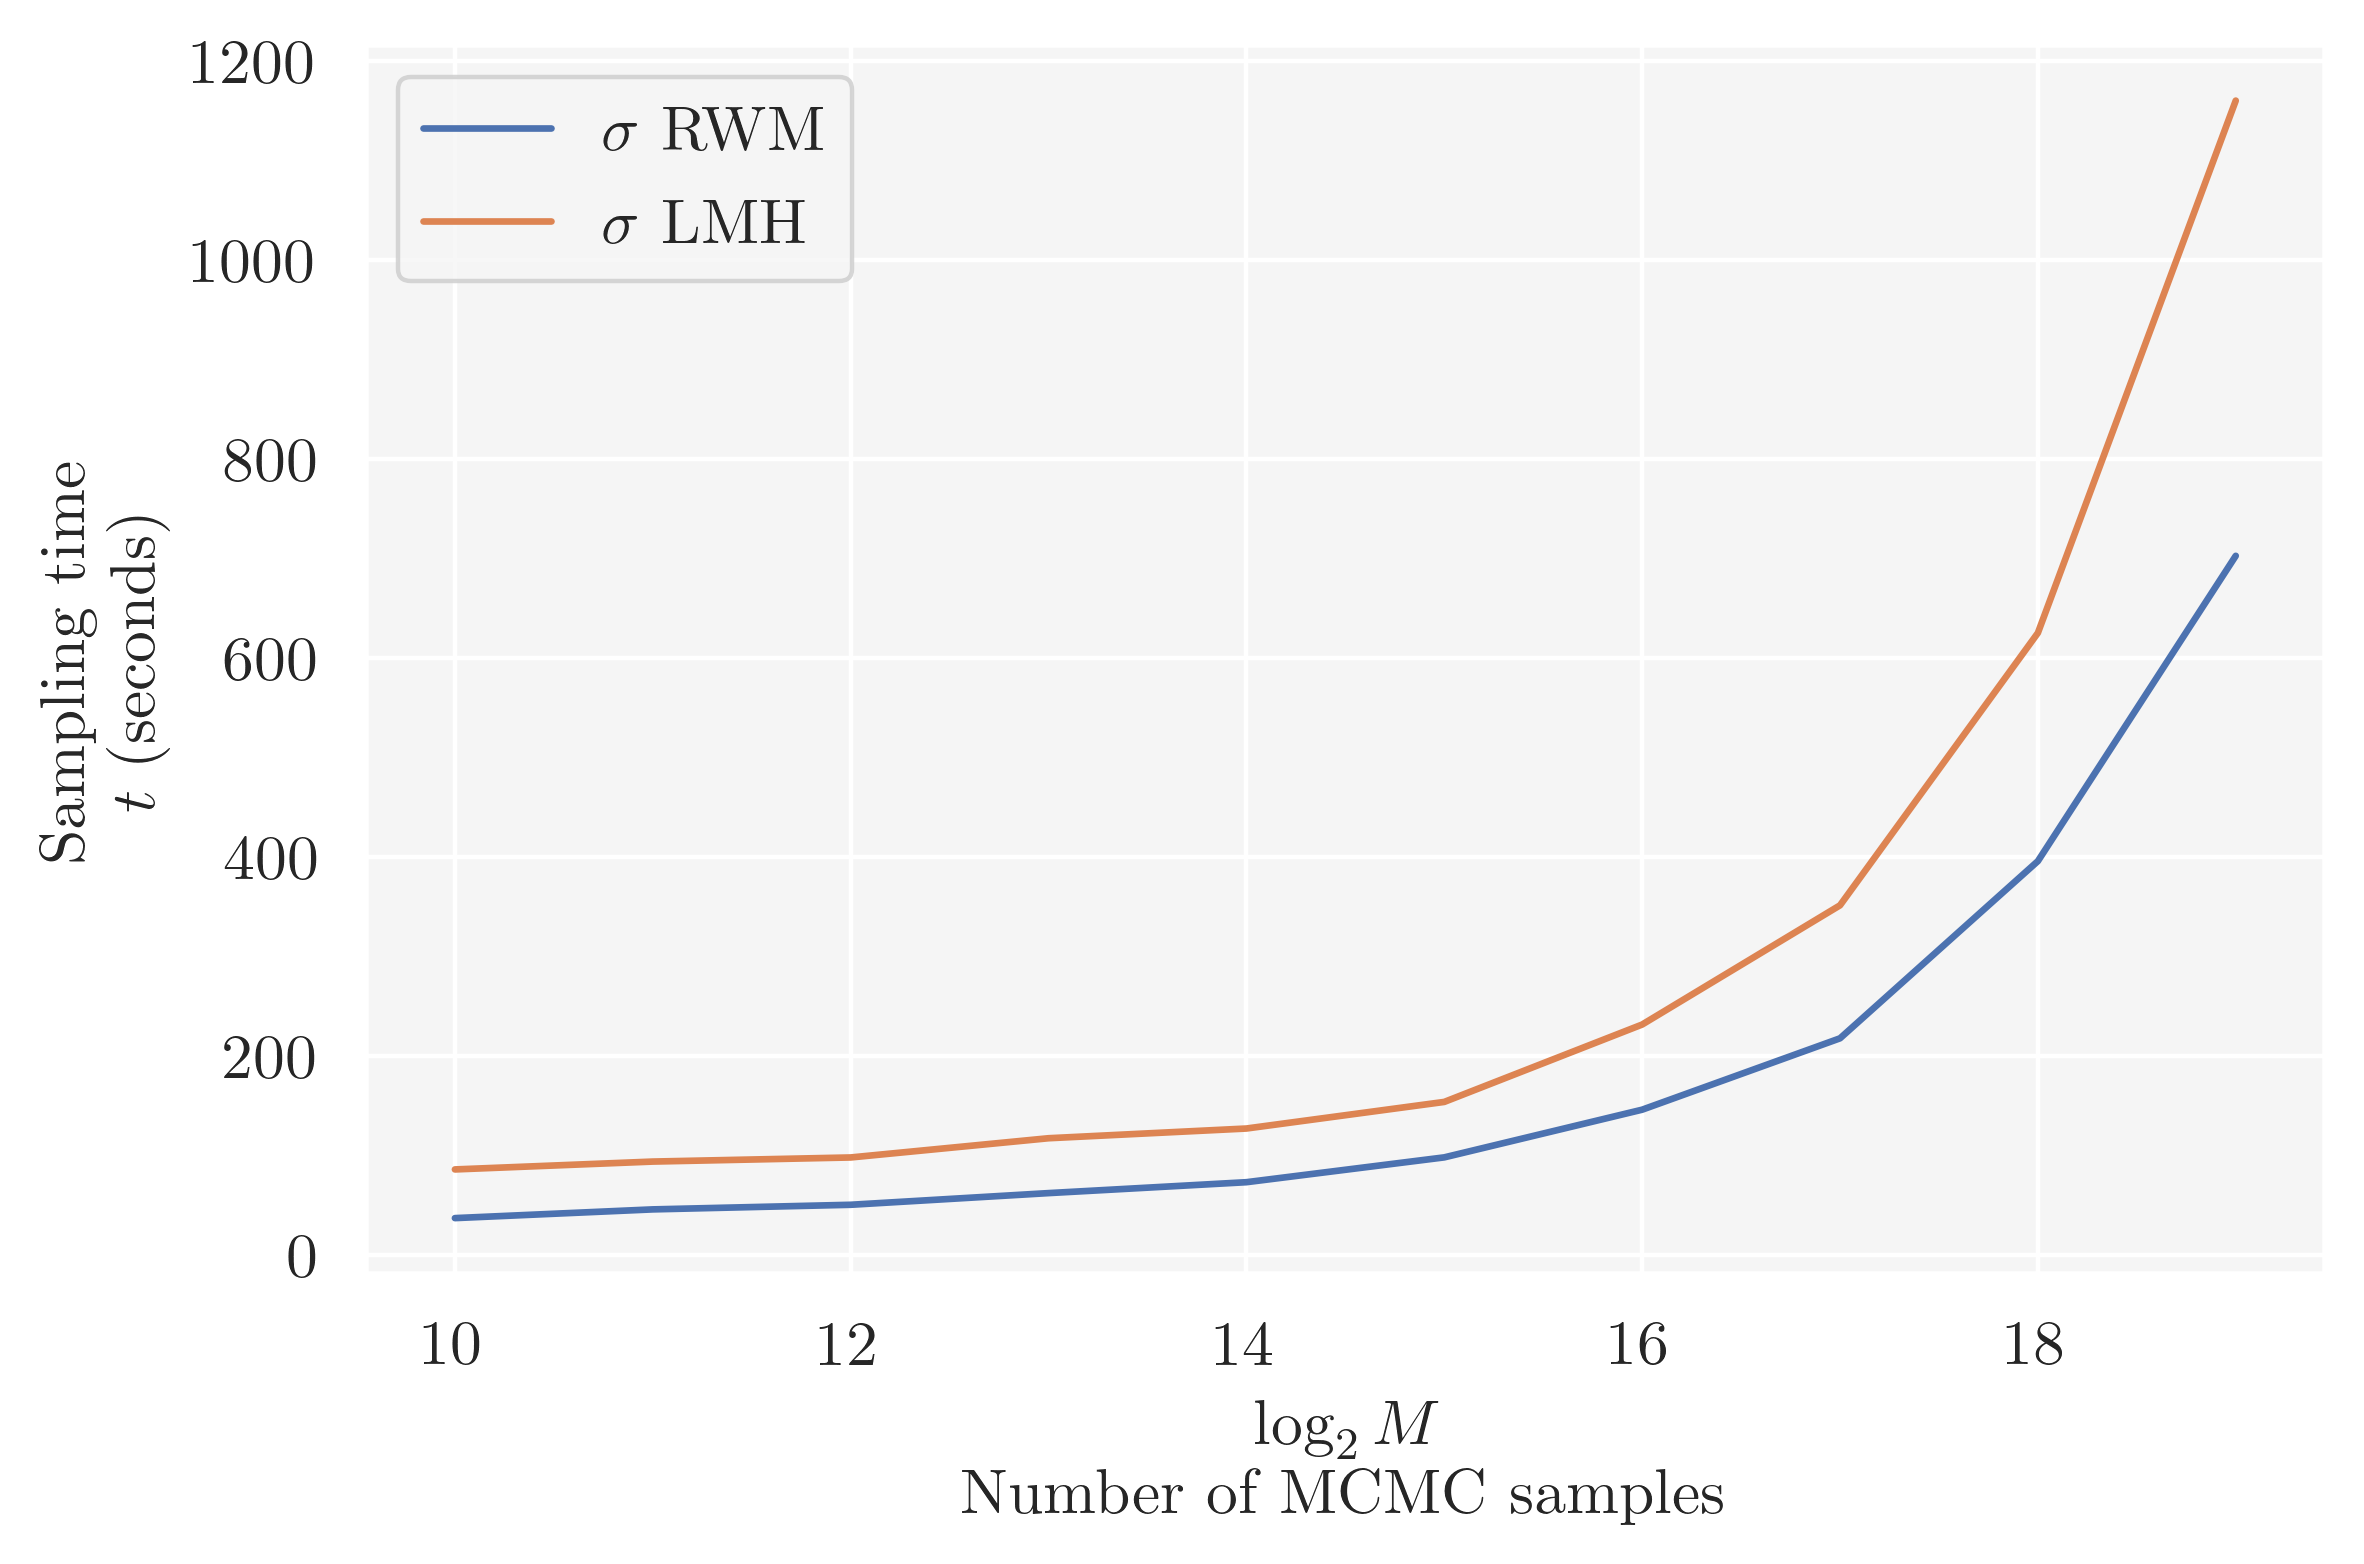

In [13]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
sns.lineplot(data=analysis_data_RWM, x="nsamples", y="sampling_time", ax=ax, label=r'$\sigma$ RWM')
sns.lineplot(data=analysis_data_LMH, x="nsamples", y="sampling_time", ax=ax, label=r'$\sigma$ LMH')
tex_xlabel = '\n'.join((r'$\log_2{M}$',
                      'Number of MCMC samples'))
tex_ylabel = '\n'.join(('Sampling time',
                        r'$t$ (seconds)'))
ax.set(xlabel=tex_xlabel, ylabel=tex_ylabel)
ax.set_xticks([10, 12, 14, 16, 18])
#ax.set_xticklabels([r'$2^{10}$',r'$2^{12}$', r'$2^{14}$', r'$2^{16}$', r'$2^{18}$'])
ax.legend()
fig.savefig(fig_path("Time_comparsion_RMW_LMH.pdf"), bbox_inches='tight')